# MBTI classification notebook

"I tweet, therefore I am..." Not really, but what we write can provide insight into our type of personality. In this competition, we aim to build a classifier that will be able to predict a person's personality based on what they write in twitter posts. The 16 MBTI personality types will be used, which is given by four binary variables as follows:

- Mind: Introverted (I) or Extroverted (E) 
- Energy: Sensing (S) or Intuitive (N) 
- Nature: Feeling (F) or Thinking (T) 
- Tactics: Perceiving (P) or Judging (J)

A training set with rows of tweets and associated personality types have been provided, as well as a test set containing only tweet posts.

Our task is to predict each one of the categories, mind, energy, nature, and tactics, separately. The combination of the four predictions will then provide the overall personality type.

The categories will be encoded as follows: 
- Mind: I = 0, E = 1 
- Energy: S = 0, N = 1 
- Nature: F = 0, T = 1 
- Tactics: P = 0, J = 1

# Data exploration and cleaning

## Loading data and constructing separate categories

In [1]:
# Import libraries for data manipulation and viewing
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load the provided training and test data into dataframes
train = pd.read_csv('./mbti_1.csv' )
test = pd.read_csv('./output.csv' )

# Check the dataframe sizes, type assignments, and missing values
print('Train info:')
train.info()
print('\nTest info:')
test.info()

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1 non-null      int64 
 1   posts       1 non-null      object
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


C:\Users\Satvik\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

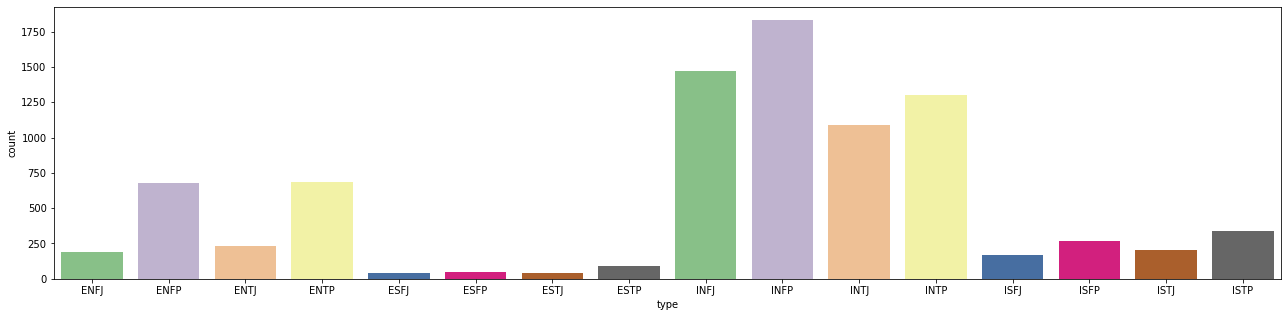

In [3]:
# View the frequencies of the personality types
plt.subplots(figsize=(22, 5))
sns.countplot(train['type'].sort_values(), palette='Accent')

From the dataframe information, we can see that the training set contains around three times more entries than the test set. Neither set has any missing values or faulty data type assignments. Looking at the counts of each personality type in the training set, it is clear that the majority of posts are from  IN__ type personalities. 

As we need to predict each personality type category individually, we will separate the categories into columns and encode them as noted above:
- Mind: I = 0, E = 1 
- Energy: S = 0, N = 1 
- Nature: F = 0, T = 1 
- Tactics: P = 0, J = 1

In [4]:
# Separate type categories
train['mind'] = train['type'].str[0]
train['energy'] = train['type'].str[1]
train['nature'] = train['type'].str[2]
train['tactics'] = train['type'].str[3]

In [5]:
# Encode category letters as either 0 or 1 
train['mind'] = train['mind'].apply(lambda x: 0 if x == 'I' else 1)
train['energy'] = train['energy'].apply(lambda x: 0 if x == 'S' else 1)
train['nature'] = train['nature'].apply(lambda x: 0 if x == 'F' else 1)
train['tactics'] = train['tactics'].apply(lambda x: 0 if x == 'P' else 1)

train.head()

,type,posts,mind,energy,nature,tactics
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,1,1,1,1


The twitter posts contain a variety of words, punctuation characters that form part of text, part of links to webpages, or indicate new tweets, various uses of capitalization, and  emoticons (emoji's) to list a few. Different personality types might have different preferences in the way they use words and text characters to express themselves. Thus, in order to use the twitter posts constructively for personality type classification, we need to preform some general text cleaning and processing.

## Text cleaning and processing

To perform the same cleaning and processing on both the training set posts and the test set posts, we will define functions for specific tasks. We can then apply the same function to both sets of posts. 

The first function uses regular expressions to identify character sequences and "clean-up" some of text in the following way:
- Webpage links would be replaced by the word 'url'.
- Twitter handles will be replaced by the word 'twithandle'
- Apostrophe suffixes would be replaced by the corresponding words. This would enable better matching and vectorization of pronouns.
- A selection of punctuation would be removed. We will not remove all punctuation as we hypothesize that the use of exclamation and question marks might differ between personalty types.
- All words would be converted to lower case.


In [6]:
import re

def word_replace(df):
    
    """Converts apostrophe suffixes to words, replace webpage links with url, annotate hashtags and mentions, remove a selection of punctuation, and convert all words to lower case.
    Args:
        df (DataFrame): dataframe containing 'posts' column to convert
    Returns:
        df (DataFrame): dataframe with converted 'posts' column 
    """

    # Change all webpage links to 'url'
    df['posts'] = df['posts'].str.replace(r'http.?://[^\s]+[\s]?', 'url ')
    
    # Replace apostrophe's with words
    df['posts'] = df['posts'].str.replace(r'n\'t', ' not')
    df['posts'] = df['posts'].str.replace(r'\'s', ' is')
    df['posts'] = df['posts'].str.replace(r'\'m', ' am')
    df['posts'] = df['posts'].str.replace(r'\'re', ' are')
    df['posts'] = df['posts'].str.replace(r'\'ve', ' have')
    df['posts'] = df['posts'].str.replace(r'\'ll', ' will')
    df['posts'] = df['posts'].str.replace(r'\'d', ' would')

    # Replace # and @ with word
    df['posts'] = df['posts'].str.replace(r'#|@', 'twithandle ')
    
    # Remove selected punctuation
    df['posts'] = df['posts'].str.replace(r"[',.():|-]", " ")

    # Convert all words to lower case
    df['posts'] = df['posts'].str.lower()
    
    return df

In [7]:
# Replace webpages, apostrophe's, selected punctuation etc.
train_clean = word_replace(train.copy())
test_clean = word_replace(test.copy())

<ipython-input-6-9974f9890a91>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['posts'] = df['posts'].str.replace(r'http.?://[^\s]+[\s]?', 'url ')
<ipython-input-6-9974f9890a91>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['posts'] = df['posts'].str.replace(r'n\'t', ' not')
<ipython-input-6-9974f9890a91>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['posts'] = df['posts'].str.replace(r'\'s', ' is')
<ipython-input-6-9974f9890a91>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['posts'] = df['posts'].str.replace(r'\'m', ' am')
<ipython-input-6-9974f9890a91>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['posts'] = df['posts'].str.replace(r'\'re', ' are')
<ipython-input-6-9974f9890a91>:20: FutureWarning: The defa

In order to turn a sequence of words of type string into a vector, we need to convert each sequence into a list of word units or tokens. There are various ways to go about it, such as to split the string on white spaces of example. As we are dealing with twitter posts, we decided to use the TweetTokenizer within the natural language toolkit (nltk) library to perform word tokenization. The TweetTokenizer will preserve emoticons when splitting string sequences into tokens.

We will also employ the nltk library, WordNetLemmatizer, to transform the word tokens to their corresponding root words (i.e. their lemma or dictionary form). 

In [8]:
# # Download NLTK libraries
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Satvik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Satvik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Satvik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Import required nltk functions 
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

get_tokens = TweetTokenizer()
get_lemmas = WordNetLemmatizer()

# Define tokenization and lemmetization function
def tokenize_lemmatize(df):
    
    """Tokenize and lemmatize posts.
    Args:
        df (DataFrame): dataframe containing 'posts' column to convert
    Returns:
        df (DataFrame): dataframe with converted 'posts' column   
    """
    
    df['posts'] = df.apply(lambda row: [get_lemmas.lemmatize(w) for w in get_tokens.tokenize(row['posts'])], axis=1)  #Tokenize and lemmatize
    
    return df

In [10]:
# Tokenize and lemmatize posts
train_clean = tokenize_lemmatize(train_clean.copy())
test_clean = tokenize_lemmatize(test_clean.copy())

As we are dealing with twitter posts that contain emoticons. As we hypothesize that different personality types might have different preferences around the use of emoticons, we will denote all emoticons with the word 'emoji'. We will again write a function in order to equally perform the transformation on both the training and test sets.
Initially, we more or less manually found the sequences and replaced the 🦄 in the posts. However, we resorted to use the emoji library to facilitate the transformations with more ease.

Some of the emoticons found in the posts are as follows:

🌹 🍄 🐍 👈 👋 👌 👍 👏 💎 💓 💖 💛 🔥 🕚 😀 😁 😂 😃 😄 😅 😆 😇 😉 😊 😋 😌 😍 😎 😏 😐 😓 😕 😘 😜 😝 😞 😡 😢 😣 😧 😫 😬 😮 😱 😳 😴 😺 🙋 🤓 🤔 🤗 🦄 ✌ ✍ ✨



*Reveal and run the code below to import the emoji library*

In [11]:
import emoji

# Create list of emoticon codes
emojies = set(emoji.UNICODE_EMOJI.keys())

# Define emoticon replacement functions
def swap_emoji(word):
    
    """Replace emoticon with 'emoji'.
    Args:
        word (str): word to replace
    Returns:
        word (str): replacement word   
    """
    
    if word in emojies:      #  replace emoticon
        return 'emoji'
    
    return word 


def emoji_convert(df):
    
    """Iterate through post and replace emoticons with 'emoji'.
    Args:
        df (DataFrame): dataframe containing 'posts' column to convert
    Returns:
        df (DataFrame): dataframe with converted 'posts' column   
    """ 
    
    df['posts'] = df['posts'].apply(lambda row: [swap_emoji(word) for word in row])   #  apply swap_emoji function to words in posts
    
    return df


In [12]:
# Substitute emoticon codes with 'emoji'
train_clean = emoji_convert(train_clean.copy())
test_clean = emoji_convert(test_clean.copy())

The English language contains multiple conjunctions and words that support sentence structure, but do not add much meaning. These words usually have a high frequency in text documents, and can be seen as noise in the text data. To decrease the noise and also decrease the number of words in the posts, we will remove these "words of little meaning" or stopwords. The nltk library have a list of such stopwords, which also include pronouns. Since we hypothesize that the use of pronouns might differ between personality types, we will remove the pronouns from the stopword list before using the list to remove stopwords from the posts.

The list of nltk English stopwords is as follows:

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [13]:
from nltk.corpus import stopwords

# List nltk English stopwords and add 'could' and 'would'
stop_words = stopwords.words('english')
stop_words = stop_words + ['could', 'would']

# Remove selected pronouns from stopword list
stop_words = [w for w in stop_words if w not in ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']]

# Define function to remove stopwords
def remove_words(df):
    
    """Remove stopwords from posts.
    Args:
        df (DataFrame): dataframe containing 'posts' column to convert
    Returns:
        df (DataFrame): dataframe with converted 'posts' column   
    """ 
    
    df['posts'] = df['posts'].apply(lambda row: [word for word in row if word not in stop_words])   #iterate through words in posts and eliminate stopwords
    
    return df

In [14]:
# Remove stop words from tokens
train_clean = remove_words(train_clean.copy())
test_clean = remove_words(test_clean.copy())

## Visualize character use by personality category

With the processed and cleaned posts, we can explore and visualize some of the word tokens.

Number of posts per personality catagory:


C:\Users\Satvik\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Satvik\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Satvik\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will

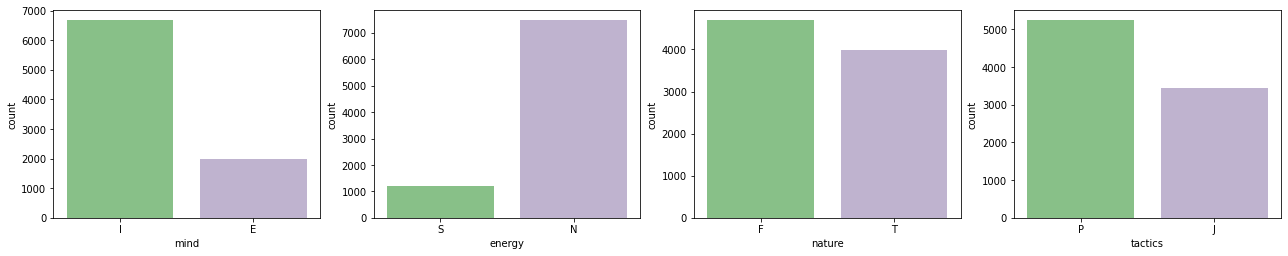

In [15]:
# Create personality catagory and annotation lists
columns = ['mind', 'energy', 'nature', 'tactics']
ticks = [('I', 'E'), ('S', 'N'), ('F', 'T'), ('P', 'J')]

# Plot the number of posts per personality category
print('Number of posts per personality catagory:')
plt.subplots(figsize=(22, 100))
for i in range(len(columns)):
    j = i+1
    plt.subplot(22,4,j)
    ax = sns.countplot(train_clean[columns[i]], palette='Accent')
    ax.set_xticklabels(ticks[i])

In [16]:
# Calculate personality category class distributions
E = train_clean['mind'][train_clean['mind'] == 1].count() / train_clean['mind'].count()
print('E:I = {} : {}'.format(round(E, 2), 1-round(E, 2)))

N = train_clean['energy'][train_clean['energy'] == 1].count() / train_clean['energy'].count()
print('N:S = {} : {}'.format(round(N, 2), 1-round(N, 2)))

T = train_clean['nature'][train_clean['nature'] == 1].count() / train_clean['nature'].count()
print('T:F = {} : {}'.format(round(T, 2), 1-round(T, 2)))

J = train_clean['tactics'][train_clean['tactics'] == 1].count() / train_clean['tactics'].count()
print('J:P = {} : {}'.format(round(J, 2), 1-round(J, 2)))

E:I = 0.23 : 0.77
N:S = 0.86 : 0.14
T:F = 0.46 : 0.54
J:P = 0.4 : 0.6


Average number of emoticons used per personality category:


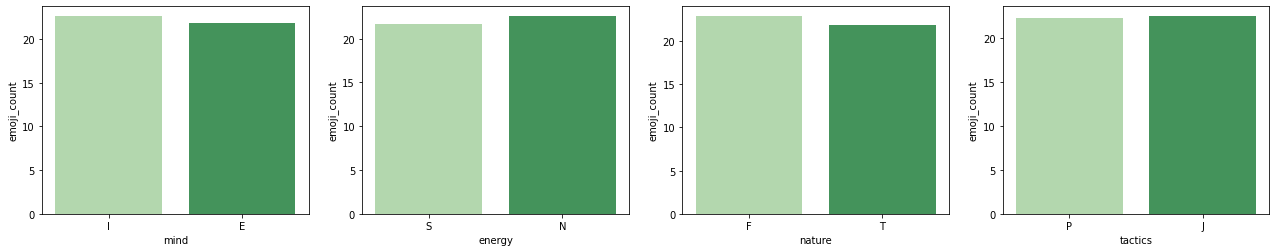

In [17]:
# Count the number of emoticons used
train_clean['emoji_count'] = train_clean['posts'].apply(lambda row: len(['emoji' for word in row if word == 'emoji']))

# Plot the average number of emoticons used per personality category
print('Average number of emoticons used per personality category:')
plt.subplots(figsize=(22, 100))
for i in range(len(columns)):
    j = i+1
    plt.subplot(22,4,j)
    df = train_clean.groupby(columns[i])[['emoji_count']].mean()
    df.index = ticks[i]
    sns.barplot(x=df.index, y=df['emoji_count'], palette='Greens')
    plt.xlabel(columns[i])

Average number of webpage links per personality category:


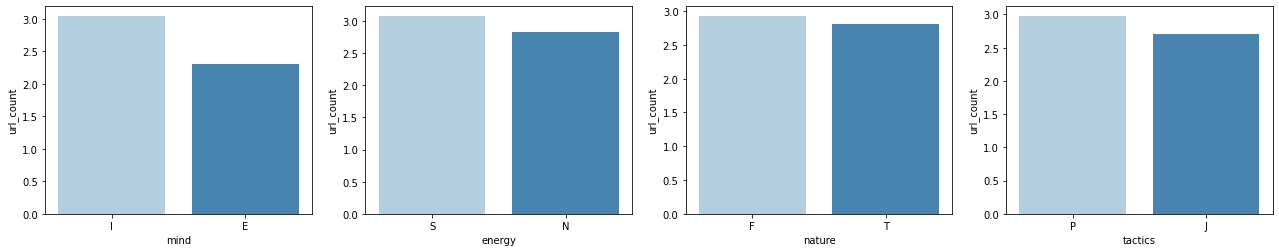

In [18]:
# Count the number of webpage links
train_clean['url_count'] = train_clean['posts'].apply(lambda row: len(['url' for word in row if word == 'url']))

# Plot the average number of webpage links per personality category
print('Average number of webpage links per personality category:')
plt.subplots(figsize=(22, 100))
for i in range(len(columns)):
    j = i+1
    plt.subplot(22,4,j)
    df = train_clean.groupby(columns[i])[['url_count']].mean()
    df.index = ticks[i]
    sns.barplot(x=df.index, y=df['url_count'], palette='Blues')
    plt.xlabel(columns[i])

Average number of exclamation marks used per personality category:


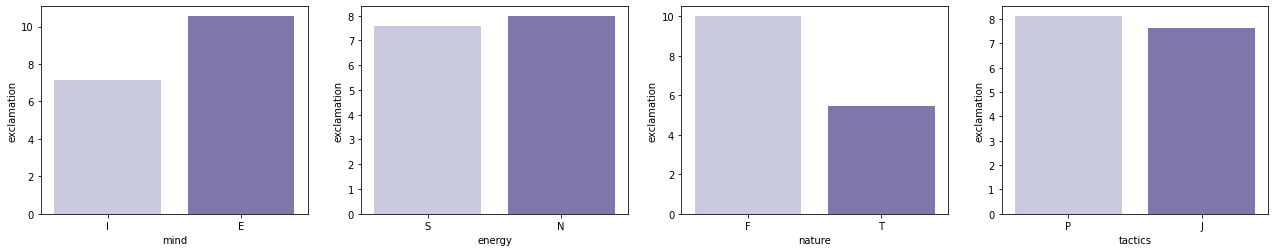

In [19]:
# Count the number of exclamation marks used
train_clean['exclamation'] = train_clean['posts'].apply(lambda row: len(['!' for word in row if word == '!']))

# Plot the average number of exclamation marks used per personality category
print('Average number of exclamation marks used per personality category:')
plt.subplots(figsize=(22, 100))
for i in range(len(columns)):
    j = i+1
    plt.subplot(22,4,j)
    df = train_clean.groupby(columns[i])[['exclamation']].mean()
    df.index = ticks[i]
    sns.barplot(x=df.index, y=df['exclamation'], palette='Purples')
    plt.xlabel(columns[i])

Average use of 'I' per personality category:


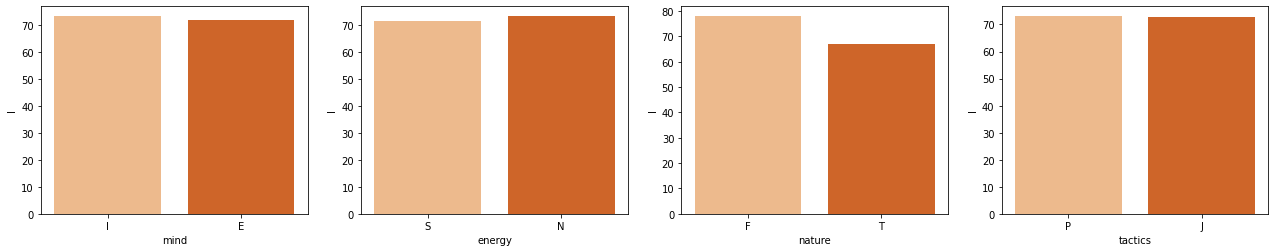

In [20]:
# Count the use of pronoun 'I'
train_clean['I'] = train_clean['posts'].apply(lambda row: len(['i' for word in row if word == 'i']))

# Plot the average number of times 'I' is used per personality category
print("Average use of 'I' per personality category:")
plt.subplots(figsize=(22, 100))
for i in range(len(columns)):
    j = i+1
    plt.subplot(22,4,j)
    df = train_clean.groupby(columns[i])[['I']].mean()
    df.index = ticks[i]
    sns.barplot(x=df.index, y=df['I'], palette='Oranges')
    plt.xlabel(columns[i])

Average use of twitter handles per personality category:


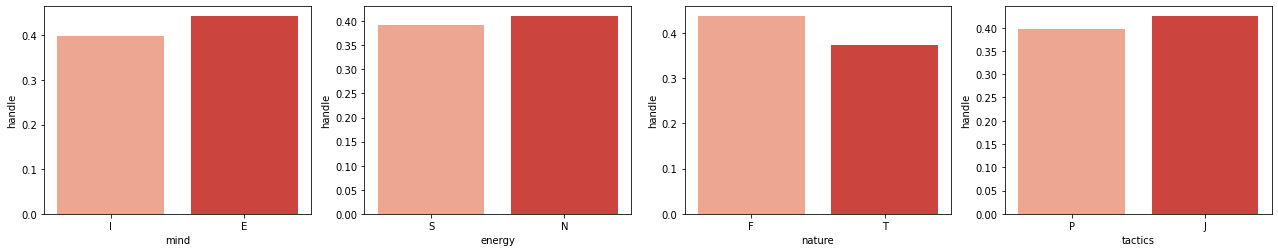

In [21]:
# Count the use of twitter handles
train_clean['handle'] = train_clean['posts'].apply(lambda row: len(['handle' for word in row if word == 'twithandle']))

# Plot the average number of twitter handles used per personality category
print("Average use of twitter handles per personality category:")
plt.subplots(figsize=(22, 100))
for i in range(len(columns)):
    j = i+1
    plt.subplot(22,4,j)
    df = train_clean.groupby(columns[i])[['handle']].mean()
    df.index = ticks[i]
    sns.barplot(x=df.index, y=df['handle'], palette='Reds')
    plt.xlabel(columns[i])

Looking at the breakdown of posts between the categories, we can again see that imbalanced classes. The biggest difference is between I and E, and S and N. As an exercise, not shown in this notebook, we have investigated both resampling with replacement, as well as sampling subsets, in order to equal out the number of posts across categories. This can be done using the sklearn.utils.resample function. However, we have found that resampling does not enhance model performance for any of the categories.

We can see that the average number of use of selected characters and tags vary between categories. From observation, not statistically speaking, we note the following:
- Emoticons: Intuitive, feeling, and judging personalities respectively tend to use more emoticons that their sensing, thinking, and perceiving counterparts.
- Webpage links: The biggest difference in the average number of webpage links posted is between introverts and extroverts.
- Exclamation marks: Introverts vs. extroverts and feeling vs. thinking personalities show the biggest difference in average use of exclamation marks.
- 'I': The average use of 'I' appears fairly similar across categories, with feeling personalities using 'I' slightly more.
- Twitter handles: The biggest difference in the average use of twitter handles appears to be between extroverts and introverts, with introverts using less handles.

All in all, there do seem to be differences in the posts from different personality types. We can thus proceed use the posts to create vectors and explore classification models. 

# Vectorization and model exploration

## TfidfVectorizer

As we would like to increase emphasis on word tokens that appear less frequent among the posts, relative to word tokens that appear in almost all posts, we decided to employ the nltk TfidfVectorizer. The TfidfVectorizer calculates the term (token) frequencies (Tf), and multiplies it by the logarithm of the ratio between the number of records and the number of records that contain the specific term (the inverse document frequency or idf). As such, it will "penalize" the term frequency according to the inverse document frequency and give more weight to less frequent, but important terms (tokens). 

In addition to the word tokens, we would also like to capture some phrase context. We therefore also investigated the inclusion of bigrams and trigrams in the vector (not shown). The inclusion of bigrams was found to provided the better predictive capability. Only tokens and bigrams that occur more than once among the training records will be included in the vector. We will again define a function to fit the vectorizer to the specified training set parameter, and subsequently vectorize both the specified training and test set parameters similarly. 

In [22]:
# Import vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialise vectorizer
tt = TfidfVectorizer(preprocessor=list, tokenizer=list, ngram_range=(1,2), min_df=2, smooth_idf=False)

# Define vectorization function
def vectorise(train_set, test_set):
    
    """Fit a vector to train_set and transform train_set and test_set accordingly. 
    Args:
        train_set (array or DataFrame): train features to vectorize
        test_set (array or DataFrame): test features to vectorize
    Returns:
        train_vect (sparse array): train_set vector
        test_vect (sparse array): test_set vector
    """
    
    tt.fit(train_set)
    train_vect = tt.transform(train_set)
    test_vect = tt.transform(test_set)
    
    return train_vect, test_vect


## Hyperparameter search with GridSearchCV


The scoring metric used for model evaluation in the Kaggle competition is the average log loss across the four personality categories. Log loss for a binary prediction is calculated as follows:

log loss = -(y\log(p) + (1 - y)\log(1 - p))

where:
- y: true class (i.e. 0 or 1)
- p: predicted probability
- log: natural logarithm

Log loss thus takes the uncertainty of the prediction into account (http://wiki.fast.ai/index.php/Log_Loss).

Since the scoring metric used requires the probability of predicting a class, we opted to investigate various classification models that are based on probability predictions to make class assignments. These include Multinomial Naive Bayes, Logistic Regression, and Random Forests. We found that Logistic Regression performed the best on the task at hand. Therefore, we will henceforth only discuss our implementation of Logistic Regression. However, with the standardized way of implementing models using sklearn libraries, it should be noted that the code below can easily be tailored to investigate all the aforementioned models. 


Logistic regression in sklearn facilitate L1 regularization when the liblinear solver in used. Since we have a large feature vector, L1 regularization will aid in reducing the number of features, as it is able to shrink coefficients to zero. Using Logistic Regression with the liblinear solver and L1 regularization then leaves the hyperparameter 'C' to be tuned. 'C' controls the amount of regularization, such that a smaller value for 'C' enforce greater regularization. 

We will use the sklearn GridSearchCV function to automatically search through a specified list of values for 'C'. As GridSearchCV maximizes the scoring metric, the negative log loss will be used. Log loss will thus in effect be minimized. The average negative log loss across four-fold cross-validation will be used for comparing the different values of 'C'.

As the different personality type categories have different distributions, and are in essence different binary classification problems, the hyperparameter 'C' will be tuned for each category separately.

In [23]:
# Import models, metrics, and model selection utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

Cross-validation uses the full complement of the training set. Therefore, the vectorizer will be fitted to the entire training set.

In [24]:
# Vectorize training posts
X_train_vect, X_test_vect = vectorise(train_clean['posts'], test_clean['posts'])
X_train_vect.shape

C:\Users\Satvik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(8675, 580998)

In [25]:
# Initialize the model to be used
cm = LogisticRegression(penalty='l1', solver='liblinear', random_state=11)

# Specify the range of 'C' parameters
params = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}

# Initialize the grid search
grid = GridSearchCV(cm, param_grid=params, scoring='neg_log_loss', n_jobs=-1, cv=4)

# Execute a grid search for each personality category
categories = ['mind', 'energy', 'nature', 'tactics']
for cat in categories:
    grid.fit(X_train_vect, train_clean[cat])
    print(cat + ':')
    print('Best score: ', -grid.best_score_)
    print('Best paramaters: ', grid.best_params_)
    print('\n')

mind:
Best score:  0.3279654288339938
Best paramaters:  {'C': 5}


energy:
Best score:  0.2424242050137334
Best paramaters:  {'C': 5}


nature:
Best score:  0.3485058254248005
Best paramaters:  {'C': 5}


tactics:
Best score:  0.4291949506141636
Best paramaters:  {'C': 5}




## Finer hyperparameter search with an isolated test set

Since the aim is to construct a model that would be able to classify unseen data, we would further "fine-tune" the hyperparameter 'C' using a hold-out test set from the training data. The "fine-tuning" was manually done with 'C' values in the range of five to seven (not all results shown). 

In [26]:
# Partition a random test set from the training data
X_train, X_test, y_train, y_test = train_test_split(train_clean['posts'], train_clean[['mind', 'energy', 'nature', 'tactics']], random_state=11)

# Vectorize the training and test sets
X_train_vect, X_test_vect = vectorise(X_train, X_test)
X_train_vect.shape

C:\Users\Satvik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(6506, 457491)

In [27]:
# Define model building function
def build_model(X_train_vect_f, X_test_vect_f, y_train_f, y_test_f, model):
    """Fit the specified model, make predictions, and calculate the log loss and confusion matrix.
    Args:
        X (array or DataFrame): independent variables
        y (array or DataFrame): dependent variable
        model (model): sklearn model and parameters
    Returns:
        train_pred (array): predictions from training data 
        test_pred (array): predictions from test data
        train_loss (float): log loss on training data
        test_loss (float): log loss on test data
        test_accuracy (float): accuracy score on test data
        test_matrix (array): confusion matrix on test data 
    """
    
    model.fit(X_train_vect_f, y_train_f)                         # fit model using training data

    train_pred = model.predict(X_train_vect_f)                   # predict training set labels
    test_pred = model.predict(X_test_vect_f)                     # predict test set labels
    
    train_proba = model.predict_proba(X_train_vect_f)            # predict label probabilities from training set
    test_proba = model.predict_proba(X_test_vect_f)              # predict label probabilities from test set
    
    train_loss = log_loss(y_train_f, train_proba, eps=1e-15)     # log loss on training data
    test_loss = log_loss(y_test_f, test_proba, eps=1e-15)        # log loss on test data   
    
    test_accuracy = accuracy_score(y_test_f, test_pred)          # accuracy score on test data
    test_matrix = confusion_matrix(y_test_f, test_pred)          # confusion matrix on test data
        
    return train_pred, test_pred, train_loss, test_loss, test_accuracy, test_matrix

In [28]:
# Initialize a list to store log loss and accuracy on test sets
ll_scores = []
ac_scores = []

In [29]:
# Initialize model for the mind category
cm = LogisticRegression(penalty='l1', solver='liblinear', C=4, random_state=11)

# Train and test the model for the mind category
pred_train, pred_test, loss_train, loss_test, acc_test, matrix_test = build_model(X_train_vect, X_test_vect, y_train['mind'], y_test['mind'], cm)
ll_scores.append(loss_test)
ac_scores.append(acc_test)
print('Mind:')
print('Log loss on training set: ',loss_train)
print('Log loss on test set: ', loss_test)
print('Accuracy on test set:', acc_test)
print('Test set confusion matrix: \n', matrix_test)

Mind:
Log loss on training set:  0.2652062640270292
Log loss on test set:  0.34263330544627096
Accuracy on test set: 0.863992623328723
Test set confusion matrix: 
 [[1590   92]
 [ 203  284]]


In [30]:
# Initialize model for the energy category
cm = LogisticRegression(penalty='l1', solver='liblinear', C=5, random_state=11)

# Train and test the model for the energy category
pred_train, pred_test, loss_train, loss_test, acc_test, matrix_test = build_model(X_train_vect, X_test_vect, y_train['energy'], y_test['energy'], cm)
ll_scores.append(loss_test)
ac_scores.append(acc_test)
print('Energy:')
print('Log loss on training set: ',loss_train)
print('Log loss on test set: ', loss_test)
print('Accuracy on test set:', acc_test)
print('Test set confusion matrix: \n', matrix_test)

Energy:
Log loss on training set:  0.18021852870209137
Log loss on test set:  0.2419389244852351
Accuracy on test set: 0.9119409866297833
Test set confusion matrix: 
 [[ 164  154]
 [  37 1814]]


In [31]:
# Initialize model for the nature category
cm = LogisticRegression(penalty='l1', solver='liblinear', C=5, random_state=11)

# Train and test the model for the nature category
pred_train, pred_test, loss_train, loss_test, acc_test, matrix_test = build_model(X_train_vect, X_test_vect, y_train['nature'], y_test['nature'], cm)
ll_scores.append(loss_test)
ac_scores.append(acc_test)
print('Nature:')
print('Log loss on training set: ',loss_train)
print('Log loss on test set: ', loss_test)
print('Accuracy on test set:', acc_test)
print('Test set confusion matrix: \n', matrix_test)

Nature:
Log loss on training set:  0.24276311957337313
Log loss on test set:  0.36748051274990545
Accuracy on test set: 0.8538497003227293
Test set confusion matrix: 
 [[1017  168]
 [ 149  835]]


In [32]:
# Initialize model for the tactics category
cm = LogisticRegression(penalty='l1', solver='liblinear', C=3, random_state=11)

# Train and test the model for the tactics category
pred_train, pred_test, loss_train, loss_test, acc_test, matrix_test = build_model(X_train_vect, X_test_vect, y_train['tactics'], y_test['tactics'], cm)
ll_scores.append(loss_test)
ac_scores.append(acc_test)
print('Tactics:')
print('Log loss on training set: ',loss_train)
print('Log loss on test set: ', loss_test)
print('Accuracy on test set:', acc_test)
print('Test set confusion matrix: \n', matrix_test)

Tactics:
Log loss on training set:  0.3801073341989999
Log loss on test set:  0.42557352862581876
Accuracy on test set: 0.8206546795758414
Test set confusion matrix: 
 [[1175  150]
 [ 239  605]]


In [33]:
print('Average log loss across personality categories: ', round(np.mean(ll_scores), 3))
print('Average accuracy across personality categories: ', round(np.mean(ac_scores), 3))

Average log loss across personality categories:  0.344
Average accuracy across personality categories:  0.863


Optimal 'C' values for each personality category was found to be as follows:
- Mind: 4
- Energy: 5
- Nature: 5
- Tactics: 3

These hyperparameter settings resulted in an average log loss of around 0.34 across the different personality type categories. In addition, for the respective categories, the log loss on the training and test sets were within 1.5-fold of each other. Thus, the models are not overfitting the training data and we can expect them to be able to generalize to unseen data.
An average accuracy score of around 86% were achieved across the models. Individually, the models also perform better than predicting the majority class of each personality category.

## Test output

In [34]:
# Initialize output dataframe
# results = test[['id']]
results = []
# Vectorize the training and test sets
X_train_vect, X_test_vect = vectorise(train_clean['posts'], test_clean['posts'])
X_train_vect.shape

C:\Users\Satvik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(8675, 580998)

### Label output

In [35]:
c_vals = [4, 5, 5, 3]      # C parameter list for final models
class1_proba = []          # List to store model probability predictions

# Train final classification models for each category
for i in range(4):
    cm = LogisticRegression(penalty='l1', solver='liblinear', C=c_vals[i], random_state=11)
    cm.fit(X_train_vect, train[categories[i]].values)
    pred_test = cm.predict(X_test_vect)                 # Predict labels
    results.append(pred_test)                            # Compile label results
    probability = cm.predict_proba(X_test_vect)         # Predict probabilities
    class1_proba.append(probability[:,1])               # Save probabilities for predicting class label 1

In [36]:
answer = ""
if (results[0] == 0):
    answer += "I"
elif (results[0] ==1):
    answer += "E"
if (results[1] == 0):
    answer += "S"
elif (results[1] ==1):
    answer += "N"
if (results[2] == 0):
    answer += "F"
elif (results[2] ==1):
    answer += "T"
if (results[3] == 0):
    answer += "P"
elif (results[3] ==1):
    answer += "J"
print(answer)
f = open("answer.txt", "w")
f.write(answer)
f.close()

INFP


# Conclusions

Predicting personality types using twitter posts relies on they hypothesis that there is a distinction between the words, phrases, topics, and style used by people of different personalities. Finding the distinctions were facilitated by the implementation of a selection of natural language processing tasks. The tasks included punctuation adjustments, labeling of similar entities such as twitter handles, webpage links, and emoticons, and the removal of "common words with little meaning" (stopwords).Taking the document frequency of words into account during vectorization helped to increase the importance of words that might be of more relevance.

As the word feature space were large, the employment of Logistic Regression models, that is capable of feature selection through regularization, proved successful. The Logistic Regression models for each personality type category generalized to unseen test data. It provided predictive capability beyond that of predicting the majority class, and afforded an accuracy across predictions of 86%.
